In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
    "unsloth/llama-3-8b-bnb-4bit", # [NEW] 15 Trillion token Llama-3
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
# Dataset Preprocessing inthe following format
#  Dataset({
#     features: ['article', 'highlights', 'id', 'text'],
#     num_rows: 11490
# })


alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["article"]
    # inputs       = examples["input"]
    outputs      = examples["highlights"]
    texts = []
    for instruction, output in zip(instructions, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format("write a concise and abstract summary of the following text: ", instruction, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", "3.0.0",split = "train",trust_remote_code=True)
dataset = dataset.map(formatting_prompts_func, batched = True,)
dataset=dataset.take(1000)


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

Dataset({
    features: ['article', 'highlights', 'id', 'text'],
    num_rows: 1000
})


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs=2.0,
        max_steps = 60,
        learning_rate = 2e-3,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.594 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
10,1.938800
20,1.857600
30,1.826500
40,1.863400
50,1.815400
60,1.822400


In [ ]:
# alpaca_prompt = Copied from above
def generate_text(text):
  FastLanguageModel.for_inference(model) # Enable native 2x faster inference
  inputs = tokenizer(
  [
      alpaca_prompt.format(
          f"""write a concise summary of the following text: {text}""", # instruction
          """ """,
          "", # output - leave this blank for generation!
      )
  ], return_tensors = "pt").to("cuda")

  outputs = model.generate(**inputs, max_new_tokens = 100, use_cache = True)
  input_string = tokenizer.batch_decode(outputs)[0].replace('\n',"")
  index = input_string.find("### Response:")
  substring = input_string[index + len("### Response:"):].strip()
  return substring



In [ ]:
import csv
dataset = load_dataset("cnn_dailymail", "3.0.0",split = "test",trust_remote_code=True)

# text="""japan 's nec corp. and UNK computer corp. of the united states said wednesday they had agreed to join forces in supercomputer sales ."""

# print(generate_text(text))

with open('first_100_testdata_llama3.csv', 'w', newline='', encoding='utf-8') as csvfile:
  # Create a CSV writer object
  writer = csv.writer(csvfile)

  # Write the header row (assuming 'article' and 'highlights' are keys)
  writer.writerow(['article', 'highlights','gen_summary'])

  # Loop through the first 1000 elements and write to CSV
  for i in range(100):
    article = dataset[i]['article']
    highlights = dataset[i]['highlights']  # Join summary sentences
    gen_summary=generate_text(article)
    writer.writerow([article, highlights,gen_summary])
    print(i)



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


16


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


18


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


25


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


31


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


39


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


49


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


50


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


51


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


52


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


53


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


54


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


55


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


56


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


57


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


58


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


60


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


61


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


62


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


63


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


64


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


65


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


66


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


67


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


68


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


69


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


70


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


71


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


72


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


73


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


74


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


75


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


76


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


77


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


78


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


79


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


80


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


81


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


82


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


83


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


84


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


85


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


86


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


87


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


88


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


89


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


90


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


91


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


92


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


93


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


94


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


95


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


96


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


97


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


98
99


In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
text="""Jordan Hill, Brittany Covington and Tesfaye Cooper, all 18, and Tanishia Covington, 24, appeared in a Chicago court on Friday. The four have been charged with hate crimes and aggravated kidnapping and battery, among other things. An online fundraiser for their victim has collected $51,000 (Â£42,500) so far. Denying the four suspects bail, Judge Maria Kuriakos Ciesil asked: "Where was your sense of decency?" Prosecutors told the court the beating started in a van and continued at a house, where the suspects allegedly forced the 18-year-old white victim, who suffers from schizophrenia and attention deficit disorder, to drink toilet water and kiss the floor. Police allege the van was earlier stolen by Mr Hill, who is also accused of demanding $300 from the victim's mother while they held him captive, according to the Chicago Tribune. The court was also told the suspects stuffed a sock into his mouth, taped his mouth shut and bound his hands with a belt. In a video made for Facebook Live which was watched millions of times, the assailants can be heard making derogatory statements against white people and Donald Trump. The victim had been dropped off at a McDonalds to meet Mr Hill - who was one of his friends - on 31 December. He was found by a police officer on Tuesday, 3 January, a day after he was reported missing by his parents. Prosecutors say the suspects each face two hate crimes counts, one because of the victim's race and the other because of his disabilities. """

inputs = tokenizer(
[
    alpaca_prompt.format(
        f"""write a concise summary of the following text: """, # instruction
        f"""{text} """,
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
write a concise summary of the following text: 

### Input:
Jordan Hill, Brittany Covington and Tesfaye Cooper, all 18, and Tanishia Covington, 24, appeared in a Chicago court on Friday. The four have been charged with hate crimes and aggravated kidnapping and battery, among other things. An online fundraiser for their victim has collected $51,000 (Â£42,500) so far. Denying the four suspects bail, Judge Maria Kuriakos Ciesil asked: "Where was your sense of decency?" Prosecutors told the court the beating started in a van and continued at a house, where the suspects allegedly forced the 18-year-old white victim, who suffers from schizophrenia and attention deficit disorder, to drink toilet water and kiss the floor. Police allege the van was earlier stolen by Mr Hill, who is also accused of demandi

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = You MUST copy from above!

inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


["<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is a famous tall tower in Paris?\n\n### Input:\n\n\n### Response:\nThe Eiffel Tower is a famous tall tower in Paris, France. It is 324 meters (1,063 feet) tall and was built in 1889 for the World's Fair. It is the most visited paid monument in the world, with over 7 million visitors annually. The tower is named after"]

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

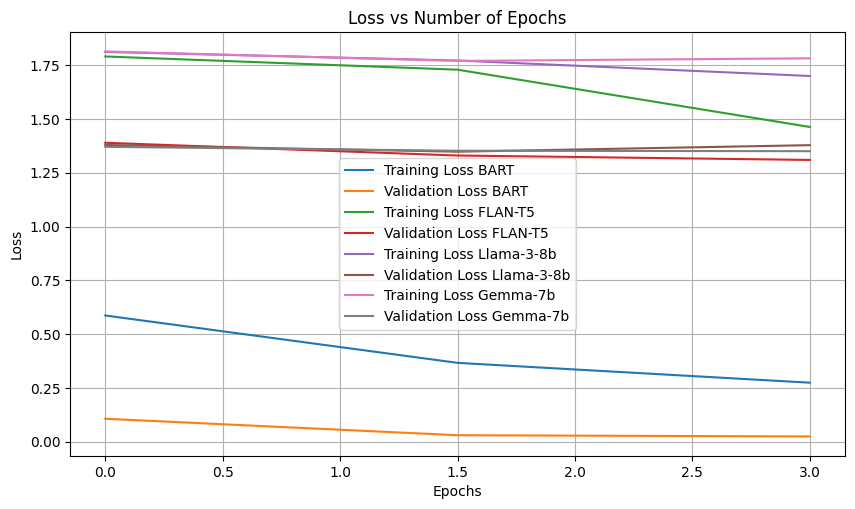

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace these with your actual data points)
epochs_train = np.linspace(0, 3,3)
epochs_validation= np.linspace(0, 3, 3)

# validation_loss_sorted = sorted(validation_loss, reverse=True)

training_loss_BART=[0.5867,0.3665,0.2743]
validation_loss_BART=[0.1066,0.0300,0.0242]

training_loss_t5=[1.7911,1.7296,1.4633]
validation_loss_t5=[1.3899,1.3305,1.3100]

training_loss_Llama=[1.8122,1.7723,1.7003]
validation_loss_Llama=[1.3795,1.3483,1.3787]

training_loss_Gemma=[1.8143,1.7705,1.7825]
validation_loss_Gemma=[1.3710,1.3527,1.3507]

# Plotting
plt.figure(figsize=(10,5.5))

plt.plot(epochs_train, training_loss_BART, label='Training Loss BART')
plt.plot(epochs_validation, validation_loss_BART, label='Validation Loss BART')

plt.plot(epochs_train, training_loss_t5, label='Training Loss FLAN-T5')
plt.plot(epochs_validation, validation_loss_t5, label='Validation Loss FLAN-T5')

plt.plot(epochs_train, training_loss_Llama, label='Training Loss Llama-3-8b')
plt.plot(epochs_validation, validation_loss_Llama, label='Validation Loss Llama-3-8b')

plt.plot(epochs_train, training_loss_Gemma, label='Training Loss Gemma-7b')
plt.plot(epochs_validation, validation_loss_Gemma, label='Validation Loss Gemma-7b')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Number of Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
